In [1]:
# default_exp plot

# Import

In [2]:
# export
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from camera_calib_python.cb_geom import cfpgrid
from camera_calib_python.modules import Inverse
from camera_calib_python.utils import *

# Extrinsics plot

In [3]:
# export
def plot_extrinsics(rigids_pos, rigids_cam, cb_geom, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.gca(projection='3d')

    # To make plot more intuitive, I've swapped the Y and Z axes

    # Matplotlib currently has poor support for setting aspect ratio of 3D plots,
    # so keep track of all points, set bounding box, then set box aspect at the end
    ps_all = [] 

    # Plot calibration boards
    ps_cb_w = cfpgrid(cb_geom.h_cb, cb_geom.w_cb)[[0,1,3,2]]
    ps_cb_w = torch.DoubleTensor(np.c_[ps_cb_w, np.zeros(len(ps_cb_w))])
    cs = sns.color_palette(None, len(rigids_pos))
    for rigid_pos, c in zip(rigids_pos, cs):
        ps_cb_root = torch2np(rigid_pos(ps_cb_w))
        ax.add_collection3d(Poly3DCollection([ps_cb_root[:,[0,2,1]]], 
                                             facecolors=c,
                                             edgecolors='k',
                                             alpha=0.5))
        ps_all.append(ps_cb_root)

    # Plot cameras
    sz_cam = np.min([cb_geom.h_cb, cb_geom.w_cb])/4 # heuristic; possibly make this an argument
    ps_axes = torch.DoubleTensor([[         0,          0,          0],
                                  [2.0*sz_cam,          0,          0],
                                  [         0,          0,          0],
                                  [         0, 2.0*sz_cam,          0],
                                  [         0,          0,          0],
                                  [         0,          0, 2.0*sz_cam]])
    ps_text = torch.DoubleTensor([[2.5*sz_cam,          0,          0],
                                  [         0, 2.5*sz_cam,          0],
                                  [         0,          0, 2.5*sz_cam]])
    pss_cam = [[[        0,        0,           0],
                [ sz_cam/2,  sz_cam/2, 1.5*sz_cam],
                [-sz_cam/2,  sz_cam/2, 1.5*sz_cam]],
               [[        0,         0,          0],
                [ sz_cam/2,  sz_cam/2, 1.5*sz_cam],
                [ sz_cam/2, -sz_cam/2, 1.5*sz_cam]],
               [[        0,         0,          0],
                [ sz_cam/2, -sz_cam/2, 1.5*sz_cam],
                [-sz_cam/2, -sz_cam/2, 1.5*sz_cam]],
               [[        0,         0,          0],
                [-sz_cam/2,  sz_cam/2, 1.5*sz_cam],
                [-sz_cam/2, -sz_cam/2, 1.5*sz_cam]],
               [[ sz_cam/2,  sz_cam/2,   sz_cam/2],
                [ sz_cam/2,  sz_cam/2,  -sz_cam/2],
                [-sz_cam/2,  sz_cam/2,  -sz_cam/2],
                [-sz_cam/2,  sz_cam/2,   sz_cam/2]],
               [[ sz_cam/2, -sz_cam/2,   sz_cam/2],
                [ sz_cam/2, -sz_cam/2,  -sz_cam/2],
                [-sz_cam/2, -sz_cam/2,  -sz_cam/2],
                [-sz_cam/2, -sz_cam/2,   sz_cam/2]],
               [[ sz_cam/2,  sz_cam/2,   sz_cam/2],
                [ sz_cam/2,  sz_cam/2,  -sz_cam/2],
                [ sz_cam/2, -sz_cam/2,  -sz_cam/2],
                [ sz_cam/2, -sz_cam/2,   sz_cam/2]],
               [[-sz_cam/2,  sz_cam/2,   sz_cam/2],
                [-sz_cam/2,  sz_cam/2,  -sz_cam/2],
                [-sz_cam/2, -sz_cam/2,  -sz_cam/2],
                [-sz_cam/2, -sz_cam/2,   sz_cam/2]],
               [[ sz_cam/2,  sz_cam/2,   sz_cam/2],
                [ sz_cam/2, -sz_cam/2,   sz_cam/2],
                [-sz_cam/2, -sz_cam/2,   sz_cam/2],
                [-sz_cam/2,  sz_cam/2,   sz_cam/2]],
               [[ sz_cam/2,  sz_cam/2,  -sz_cam/2],
                [ sz_cam/2, -sz_cam/2,  -sz_cam/2],
                [-sz_cam/2, -sz_cam/2,  -sz_cam/2],
                [-sz_cam/2,  sz_cam/2,  -sz_cam/2]]] # TODO: Do one face and rotate it instead
    pss_cam = [torch.DoubleTensor(ps_cam) for ps_cam in pss_cam]
    for rigid_cam in rigids_cam:
        ps_axes_root = torch2np(Inverse(rigid_cam)(ps_axes))
        ax.quiver(ps_axes_root[::2,0], ps_axes_root[::2,2], ps_axes_root[::2,1],
                  ps_axes_root[1::2,0]-ps_axes_root[::2,0],
                  ps_axes_root[1::2,2]-ps_axes_root[::2,2],
                  ps_axes_root[1::2,1]-ps_axes_root[::2,1],
                  color='r')

        ps_text_root = torch2np(Inverse(rigid_cam)(ps_text))
        ax.text(*ps_text_root[0, [0,2,1]], 'x')
        ax.text(*ps_text_root[1, [0,2,1]], 'y')
        ax.text(*ps_text_root[2, [0,2,1]], 'z')

        pss_cam_root = [torch2np(Inverse(rigid_cam)(ps_cam)) for ps_cam in pss_cam]
        ax.add_collection3d(Poly3DCollection([ps_cam_root[:,[0,2,1]] for ps_cam_root in pss_cam_root], 
                                             facecolors='k', 
                                             alpha=0.5))

        ps_all.append(ps_axes_root)
        ps_all.append(ps_text_root)
        ps_all += pss_cam_root

    # Format plot
    ps_all = np.concatenate(ps_all)
    bb = ps_bb(ps_all)
    ax.set_xlim(bb[0,0], bb[1,0])
    ax.set_ylim(bb[0,2], bb[1,2])
    ax.set_zlim(bb[0,1], bb[1,1])
    ax.set_box_aspect((bb[1]-bb[0])[[0,2,1]])
    ax.invert_zaxis()

# Test

In [4]:
[cams, distorts, rigids_pos, rigids_cam, cb_geom] = torch.load('data/dot_vision_checker/calib.pth')
cams, distorts, rigids_pos, rigids_cam, cb_geom

([CamSF(alpha:3.59e+03 x_o:974.5 y_o:763.5),
  CamSF(alpha:3.572e+03 x_o:1.038e+03 y_o:788.0),
  CamSF(alpha:3.48e+03 x_o:1.118e+03 y_o:734.3)],
 [Heikkila97Distortion(k1:-0.1926 k2:1.598 p1:-0.001477 p2:0.00161),
  Heikkila97Distortion(k1:-0.1638 k2:0.2258 p1:0.0007336 p2:0.001331),
  Heikkila97Distortion(k1:-0.1555 k2:0.1097 p1:0.0005519 p2:0.0001337)],
 [Rigid(
    (ms): ModuleList(
      (0): EulerRotation(ex:-0.7128 ey:0.1347 ez:2.305)
      (1): Translation(tx:14.52 ty:2.888 tz:184.9)
    )
  ), Rigid(
    (ms): ModuleList(
      (0): EulerRotation(ex:-0.7279 ey:-0.1549 ez:1.754)
      (1): Translation(tx:2.484 ty:5.448 tz:175.0)
    )
  )],
 [Rigid(
    (ms): ModuleList(
      (0): EulerRotation(ex:0.0 ey:-0.0 ez:0.0)
      (1): Translation(tx:0.0 ty:0.0 tz:0.0)
    )
  ), Rigid(
    (ms): ModuleList(
      (0): EulerRotation(ex:0.003261 ey:0.3904 ez:-0.003991)
      (1): Translation(tx:-83.43 ty:0.0831 tz:-7.064)
    )
  ), Rigid(
    (ms): ModuleList(
      (0): EulerRotation(

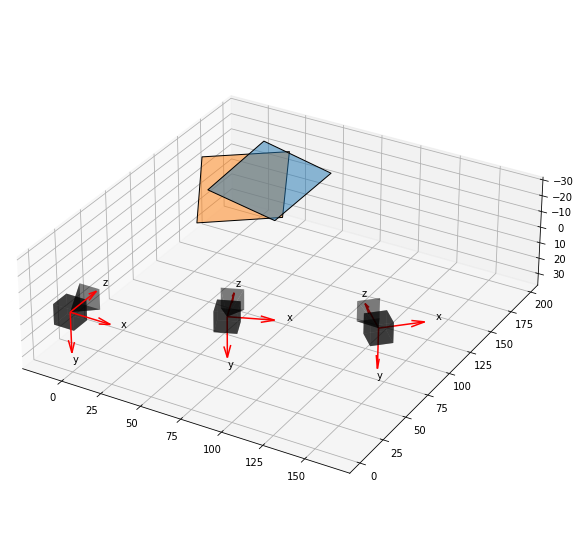

In [5]:
plot_extrinsics(rigids_pos, rigids_cam, cb_geom)

# Build

In [6]:
!nbdev_build_lib

Converted README.ipynb.
Converted calib.ipynb.
Converted cb_geom.ipynb.
Converted control_refine.ipynb.
Converted fiducial_detect.ipynb.
Converted image.ipynb.
Converted modules.ipynb.
Converted plot.ipynb.
Converted utils.ipynb.
